In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob
import random
import shutil
import warnings
import json
import itertools
import numpy as np
import pandas as pd
from collections import Counter

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from PIL import Image

from sklearn.model_selection import train_test_split

# Defining the working directories
work_dir = '/content/drive/MyDrive/cassava-leaf-disease-classification/'
os.listdir(work_dir) 
train_path = '/content/drive/MyDrive/cassava-leaf-disease-classification/train_images'

In [ ]:

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
with tf.device('/GPU:0'):
    print('Yes, there is GPU')
    
tf.debugging.set_log_device_placement(True)



Num GPUs Available:  1
Yes, there is GPU


In [ ]:
data = pd.read_csv(work_dir + 'train.csv')
print(data['label'].value_counts()) # Checking the frequencies of the labels



3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64


In [ ]:
# Importing the json file with labels
with open(work_dir + 'label_num_to_disease_map.json') as f:
    real_labels = json.load(f)
    real_labels = {int(k):v for k,v in real_labels.items()}
    
# Defining the working dataset
data['class_name'] = data['label'].map(real_labels)

real_labels

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

In [ ]:
train, test = train_test_split(data, test_size = 0.05, random_state = 42, stratify = data['class_name'])

In [ ]:
IMG_SIZE = 456
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 5
BATCH_SIZE = 15

In [ ]:
datagen_train = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest',
)

datagen_val = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
)

In [ ]:
train_set = datagen_train.flow_from_dataframe(
    train,
    directory=train_path,
    seed=42,
    x_col='image_id',
    y_col='class_name',
    target_size = size,
    class_mode='categorical',
    interpolation='nearest',
    shuffle = True,
    batch_size = BATCH_SIZE,
)

test_set = datagen_val.flow_from_dataframe(
    test,
    directory=train_path,
    seed=42,
    x_col='image_id',
    y_col='class_name',
    target_size = size,
    class_mode='categorical',
    interpolation='nearest',
    shuffle=True,
    batch_size=BATCH_SIZE,    
)

Found 20327 validated image filenames belonging to 5 classes.
Found 1070 validated image filenames belonging to 5 classes.


In [ ]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3

In [ ]:
def create_model():
    
    model = Sequential()
    # initialize the model with input shape
    model.add(
        EfficientNetB3(
            input_shape = (IMG_SIZE, IMG_SIZE, 3), 
            include_top = False,
            weights='imagenet',
            drop_connect_rate=0.65,
        )
    )
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(
        128, 
        activation='relu', 
    ))
    model.add(Dense(
        256, 
        activation='relu', 
        bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)
    ))
    model.add(Dropout(0.5))
    model.add(Dense(n_CLASS, activation = 'softmax'))
    
    return model

leaf_model = create_model()
leaf_model.summary()

43941888/43941136 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 15, 15, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________

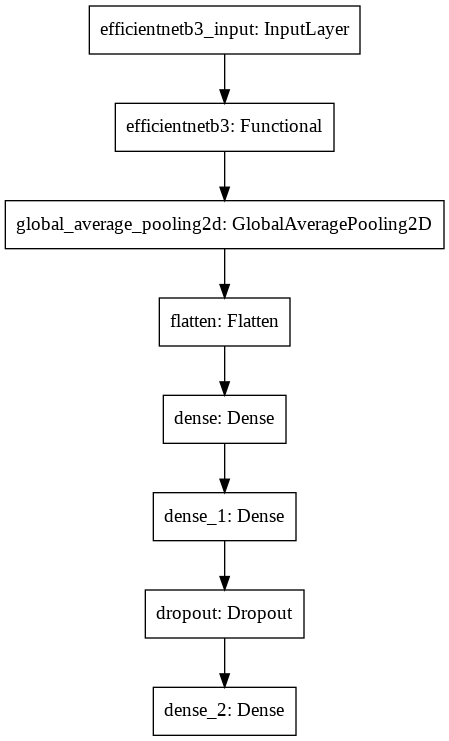

In [ ]:
keras.utils.plot_model(leaf_model)

In [ ]:
EPOCHS = 15
STEP_SIZE_TRAIN = train_set.n // train_set.batch_size
STEP_SIZE_TEST = test_set.n // test_set.batch_size

In [ ]:
def model_fit():
    leaf_model = create_model()
    
    # Loss function 
    # https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy
    loss = tf.keras.losses.CategoricalCrossentropy(
        from_logits = False,
        label_smoothing=0.0001,
        name='categorical_crossentropy'
    )
    
    # Compile the model
    leaf_model.compile(
        optimizer = Adam(learning_rate = 1e-3),
        loss = loss, #'categorical_crossentropy'
        metrics = ['categorical_accuracy']
    )
    
    # Stop training when the val_loss has stopped decreasing for 3 epochs.
    # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
    es = EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        patience=3,
        restore_best_weights=True, 
        verbose=1,
    )
    
    # Save the model with the minimum validation loss
    # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
    checkpoint_cb = ModelCheckpoint(
        "Cassava_best_model.h5",
        save_best_only=True,
        monitor='val_loss',
        mode='min',
    )
    
    # Reduce learning rate once learning stagnates
    # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6,
        mode='min',
        verbose=1,
    )
    
    # Fit the model
    history = leaf_model.fit(
        train_set,
        validation_data=test_set,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        steps_per_epoch=STEP_SIZE_TRAIN,
        validation_steps=STEP_SIZE_TEST,
        callbacks=[es, checkpoint_cb, reduce_lr],
    )
    
    # Save the model
    leaf_model.save('Cassava_model'+'.h5')  
    
    return history




In [ ]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

from tensorflow.compat.v1.keras import backend as K
K.set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [ ]:
try:
    final_model = keras.models.load_model('Cassava_model.h5')
except Exception as e:
    with tf.device('/GPU:0'):
        results = model_fit()
    print('Train Categorical Accuracy: ', max(results.history['categorical_accuracy']))
    print('Test Categorical Accuracy: ', max(results.history['val_categorical_accuracy']))

Epoch 1/15
1355/1355 [==============================] - 9363s 7s/step - loss: 0.8768 - categorical_accuracy: 0.6940 - val_loss: 0.5077 - val_categorical_accuracy: 0.8404
Epoch 2/15
1355/1355 [==============================] - 1669s 1s/step - loss: 0.5550 - categorical_accuracy: 0.8100 - val_loss: 0.4902 - val_categorical_accuracy: 0.8413
Epoch 3/15
1355/1355 [==============================] - 1670s 1s/step - loss: 0.5089 - categorical_accuracy: 0.8306 - val_loss: 0.5365 - val_categorical_accuracy: 0.8254
Epoch 4/15
1355/1355 [==============================] - 1670s 1s/step - loss: 0.4941 - categorical_accuracy: 0.8360 - val_loss: 0.4834 - val_categorical_accuracy: 0.8376
Epoch 5/15
1355/1355 [==============================] - 1672s 1s/step - loss: 0.4599 - categorical_accuracy: 0.8436 - val_loss: 0.8216 - val_categorical_accuracy: 0.7014
Epoch 6/15
1355/1355 [==============================] - 1671s 1s/step - loss: 0.4747 - categorical_accuracy: 0.8425 - val_loss: 0.4277 - val_categoric

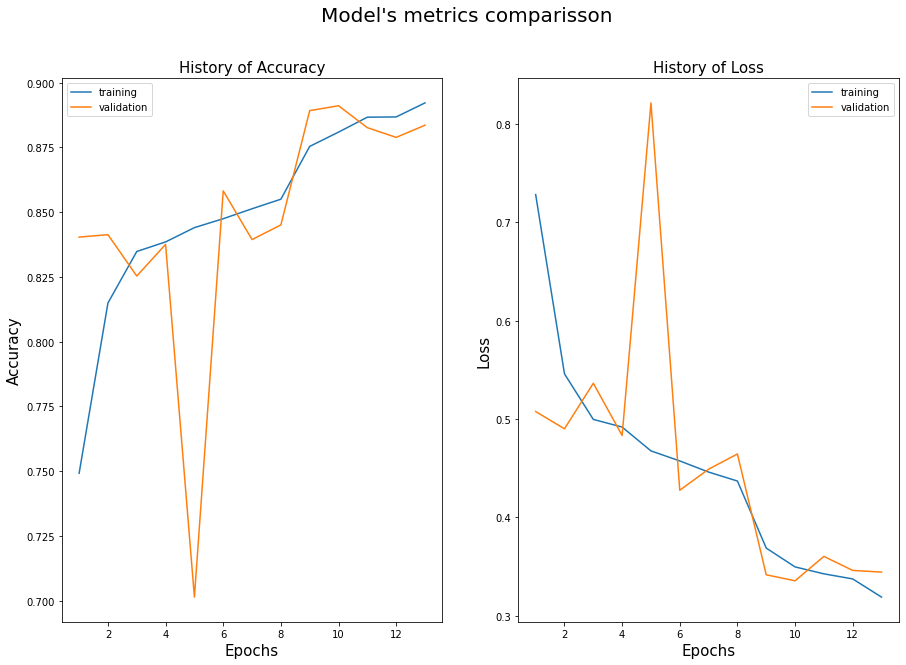

In [ ]:
#@title
def trai_test_plot(acc, test_acc, loss, test_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle("Model's metrics comparisson", fontsize=20)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(test_acc) + 1), test_acc)
    ax1.set_title('History of Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(test_loss) + 1), test_loss)
    ax2.set_title('History of Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()
    
trai_test_plot(
    results.history['categorical_accuracy'],
    results.history['val_categorical_accuracy'],
    results.history['loss'],
    results.history['val_loss']
)